# That last one

We are not gonna do a lot of new things today. Mostly we'll just combine what you have learned in order to make our final prediction. It is important that you have successfully run week12split.ipynb (in geo_env) before starting on this exercises (in xgb_env). The reason is that we a going to use the pickles generated in week12split.ipynb Lets get to it.

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm

import pickle
import time

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
pkl_file = open('y_train_week12.pkl', 'rb')
y_train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('X_train_week12.pkl', 'rb')
X_train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('y_val_week12.pkl', 'rb')
y_val = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('X_val_week12.pkl', 'rb')
X_val = pickle.load(pkl_file)
pkl_file.close()

In [3]:
print(y_train.shape)
print(X_train.shape)
print(y_val.shape)
print(X_val.shape)

(1555632, 5)
(1555632, 56)
(64818, 5)
(64818, 56)


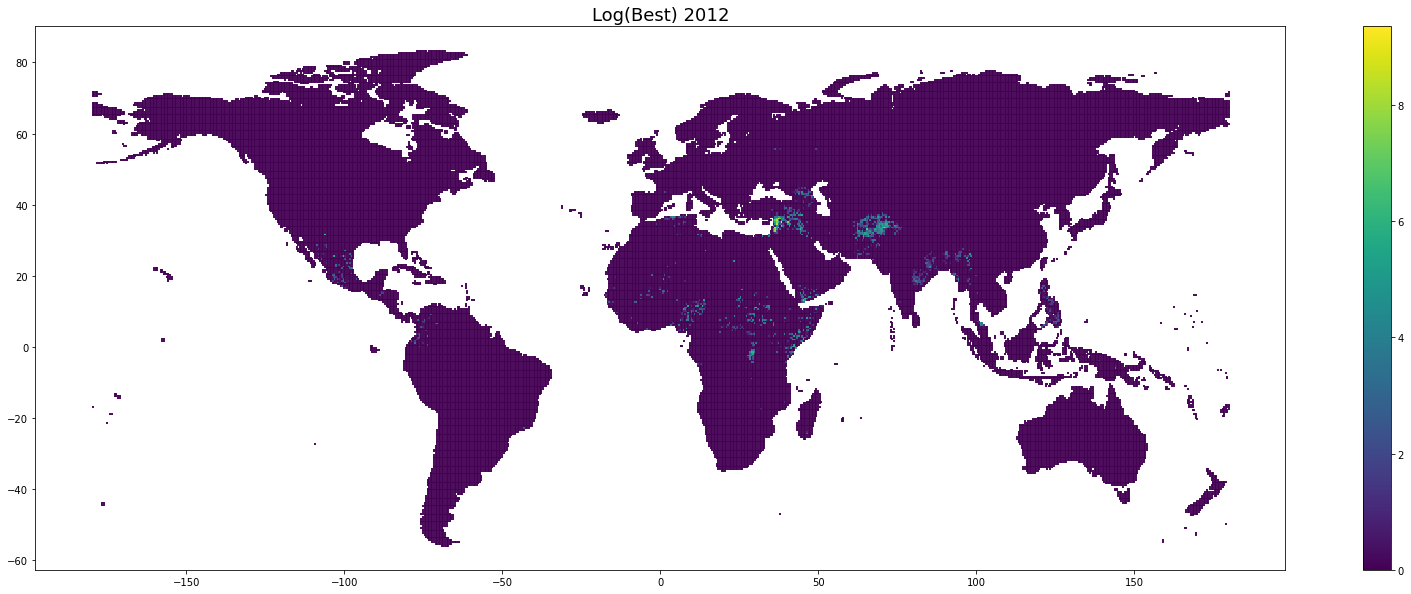

In [4]:
plt.figure(figsize = [28,10])
plt.title('Log(Best) 2012', fontsize = 18)
plt.scatter(X_train[X_train['year'] == 2012]['xcoord'], X_train[X_train['year'] == 2012]['ycoord'], c = X_train[X_train['year'] == 2012]['log_best'], s=1, marker='s')
plt.colorbar()
plt.show()

In [5]:
model = XGBClassifier(n_estimators=16, random_state = 42)# 16 estimators is very low. Try 32, 64 or 128 if you have the time
model.fit(X_train, y_train['binary_best_t1'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=16, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_val_pred = model.predict_proba(X_val)[:,1]

In [7]:
AUC_train = metrics.roc_auc_score(y_train['binary_best_t1'], y_train_pred)
AP_train = metrics.average_precision_score(y_train['binary_best_t1'], y_train_pred)
BS_train = metrics.brier_score_loss(y_train['binary_best_t1'], y_train_pred)

AUC_val = metrics.roc_auc_score(y_val['binary_best_t1'], y_val_pred)
AP_val = metrics.average_precision_score(y_val['binary_best_t1'], y_val_pred)
BS_val = metrics.brier_score_loss(y_val['binary_best_t1'], y_val_pred)

print(f'\tTrain\tVal\nAUC: \t{AUC_train:.3f}\t{AUC_val:.3f}\nAP: \t{AP_train:.3f}\t{AP_val:.3f}\nBS: \t{BS_train:.3f}\t{BS_val:.3f}')

	Train	Val
AUC: 	0.994	0.970
AP: 	0.736	0.643
BS: 	0.006	0.010


In [8]:
grid = X_train[X_train['year'] == 2012 ][['xcoord','ycoord']].copy()# does not matter wich year you take as long as you only pick one

In [9]:
grid['predected_probs_1t'] = model.predict_proba(X_val)[:,1] 

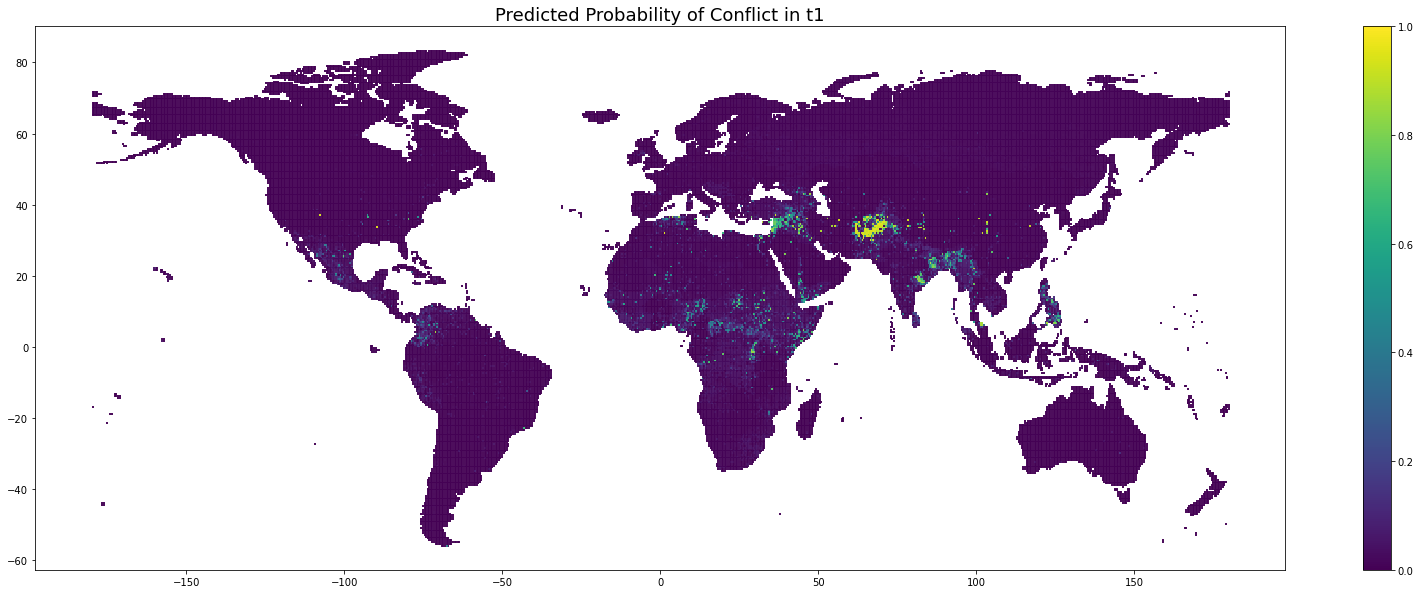

In [10]:
plt.figure(figsize = [28,10])
plt.title('Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['predected_probs_1t'], s=1, marker='s', vmin = 0, vmax =1)
plt.colorbar()
plt.show()

We make our own Ensamble - nothing fancy

In [11]:
preds = []
n_rounds = 100

for i in range(n_rounds):

    n_estimators = np.random.randint(8,32)
    max_depth = np.random.randint(2,6)
    gamma = np.random.uniform(0.1, 1)
    reg_lambda = np.random.uniform(0.1, 0.5)
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, gamma = gamma, reg_lambda = reg_lambda, random_state = i)
    
    model.fit(X_train, y_train['binary_best_t1'])
    y_val_pred = model.predict_proba(X_val)[:,1]
    preds.append(y_val_pred)
    
    print(f'{i+1}/{n_rounds} done')
    

1/5 done
2/5 done
3/5 done
4/5 done
5/5 done


In [12]:
grid['ensample_mean_t1'] = np.array(preds).mean(axis = 0)
grid['ensample_std_t1'] = np.array(preds).std(axis = 0)

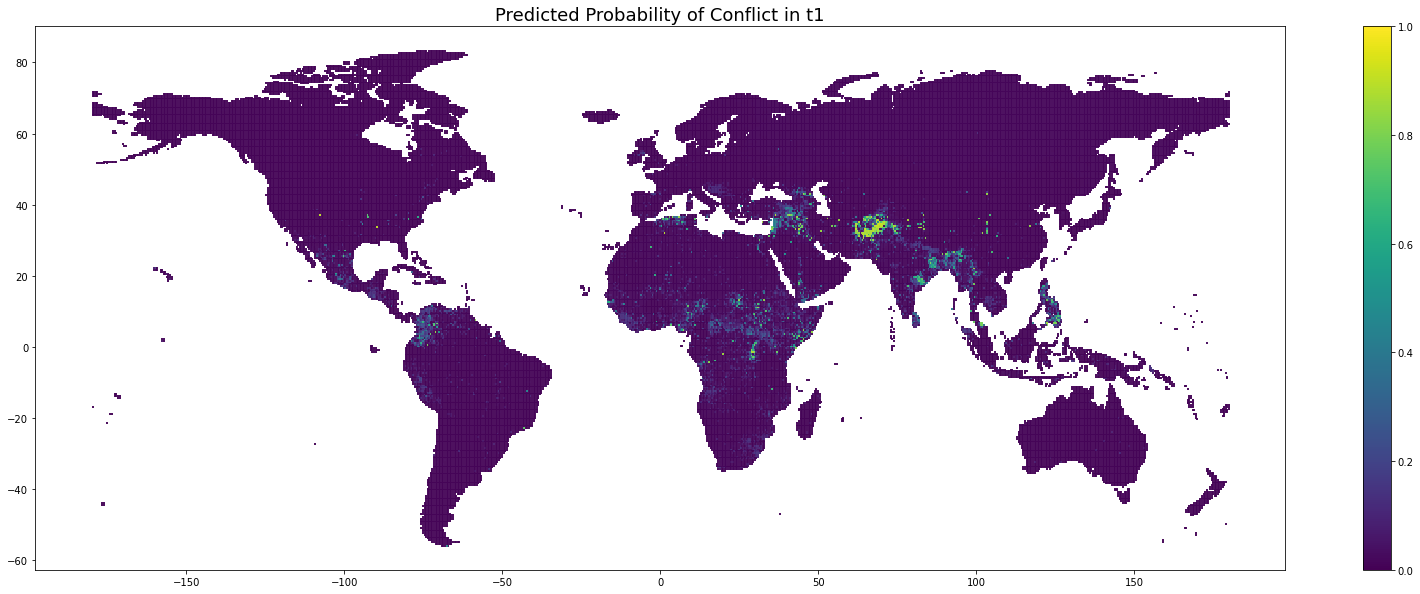

In [13]:
plt.figure(figsize = [28,10])
plt.title('Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['ensample_mean_t1'], s=1, marker='s', vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

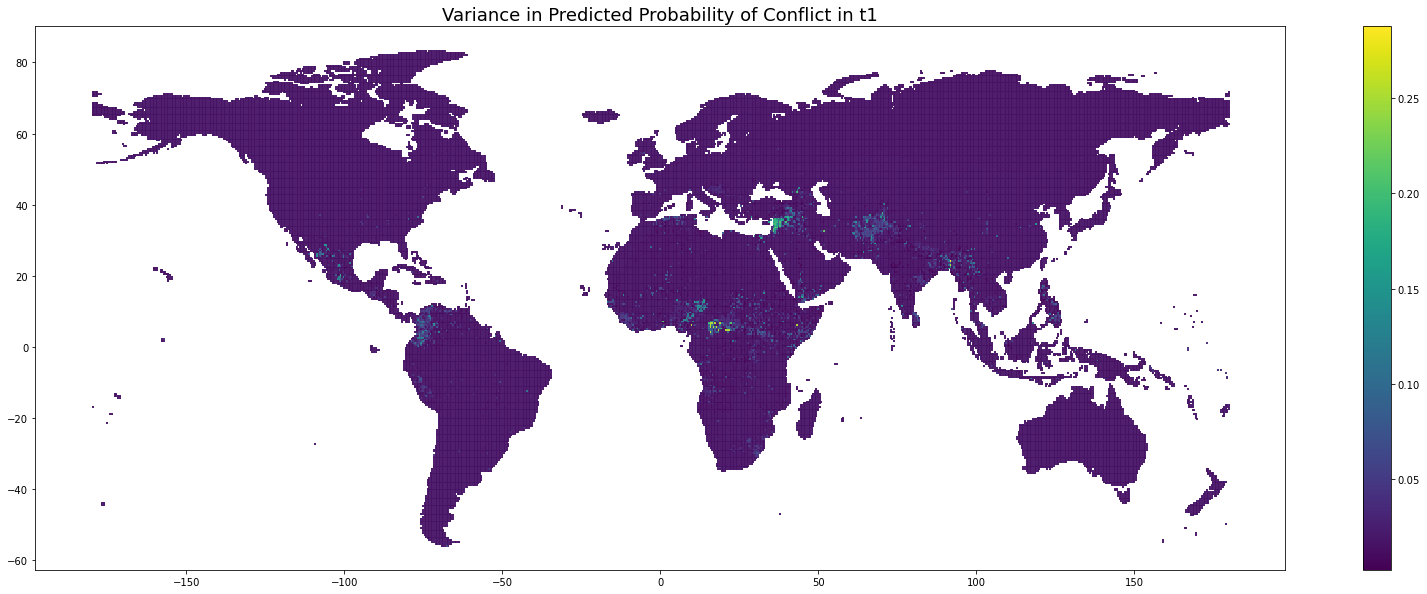

In [14]:
plt.figure(figsize = [28,10])
plt.title('Variance in Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['ensample_std_t1'], s=1, marker='s')
plt.colorbar()
plt.show()

In [15]:
AP_list = []
pr_list = []

for pred in preds:

    AP_val = metrics.average_precision_score(y_val['binary_best_t1'], pred)
    AP_list.append(AP_val)
    
    precision_val, recall_val, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], pred) 
    pr_list.append((precision_val, recall_val))

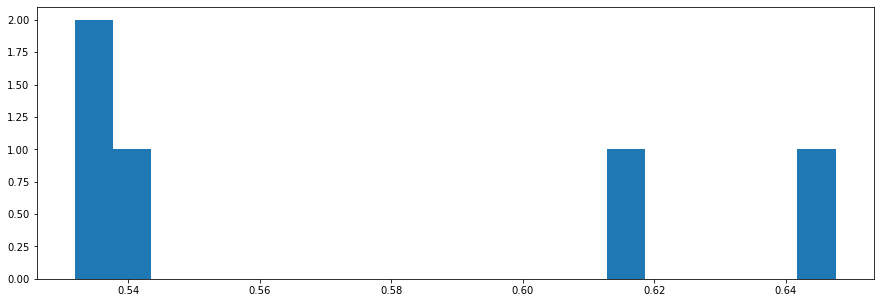

In [16]:
plt.figure(figsize = [15,5])
plt.hist(AP_list, bins = 20)
plt.show()

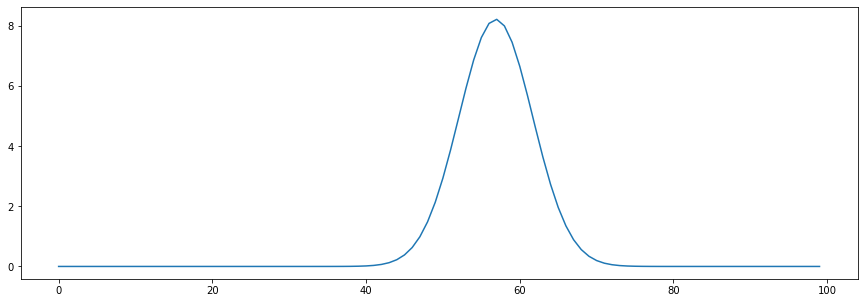

In [17]:
ap_mean = np.array(AP_list).mean()
ap_std = np.array(AP_list).std()
x = np.linspace(0,1,100)

ap_norm = scipy.stats.norm.pdf(x, loc=ap_mean, scale=ap_std)

plt.figure(figsize = [15,5])
plt.plot(ap_norm)
plt.show()

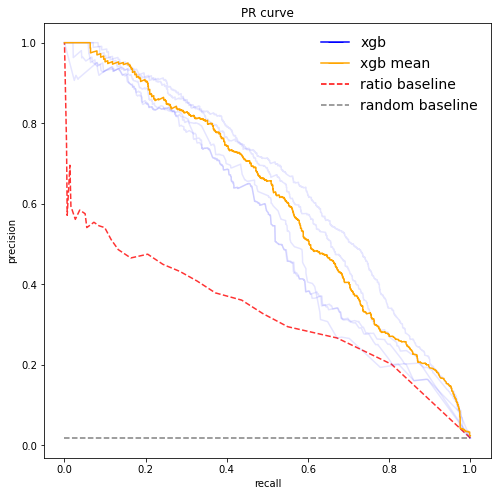

In [18]:
random_base = (y_val['binary_best_t1']>0).mean()
ratio_base_precision, ratio_base_recall, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], X_val['ratio_best']) 
xgb_mean_precision, xgb_mean_recall, _ = metrics.precision_recall_curve(y_val['binary_best_t1'],grid['ensample_mean_t1']) 

plt.figure(figsize = [8,8])

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.plot(ratio_base_recall,ratio_base_precision, '--', color = 'red', alpha = 0.8, label = 'ratio baseline')
plt.hlines(random_base, 0, 1, linestyles='dashed', color = 'gray', label = 'random baseline')

for i in pr_list: 
    
    plt.plot(i[1], i[0], color = 'blue', alpha = 0.1)
    
plt.plot(xgb_mean_recall,xgb_mean_precision, color = 'orange', alpha = 1, label = 'xgb mean')

    
xgb_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
xgb_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label='xgb mean')
random_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')
ratio_line = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='ratio baseline')

plt.legend(handles=[xgb_line, xgb_mean_line, ratio_line, random_line],frameon = False, fontsize = 14)
    

plt.show()

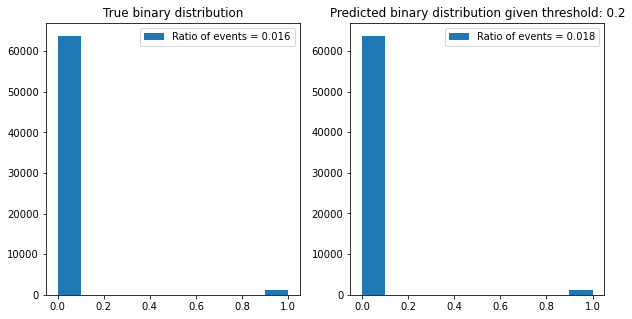

In [19]:
plt.figure(figsize = [10,5])

events_lastY = X_train[X_train['year'] == X_train['year'].max()]['binary_best']

plt.subplot(1,2,1, title = 'True binary distribution')
plt.hist(events_lastY, density = False, label = f'Ratio of events = {events_lastY.mean():.2}')
plt.legend()

threshold = 0.2
events_predicted = (grid['ensample_mean_t1']>=threshold)*1

plt.subplot(1,2,2, title = f'Predicted binary distribution given threshold: {threshold}')
plt.hist(events_predicted, density = False, label = f'Ratio of events = {events_predicted.mean():.2}')
plt.legend()
plt.show()

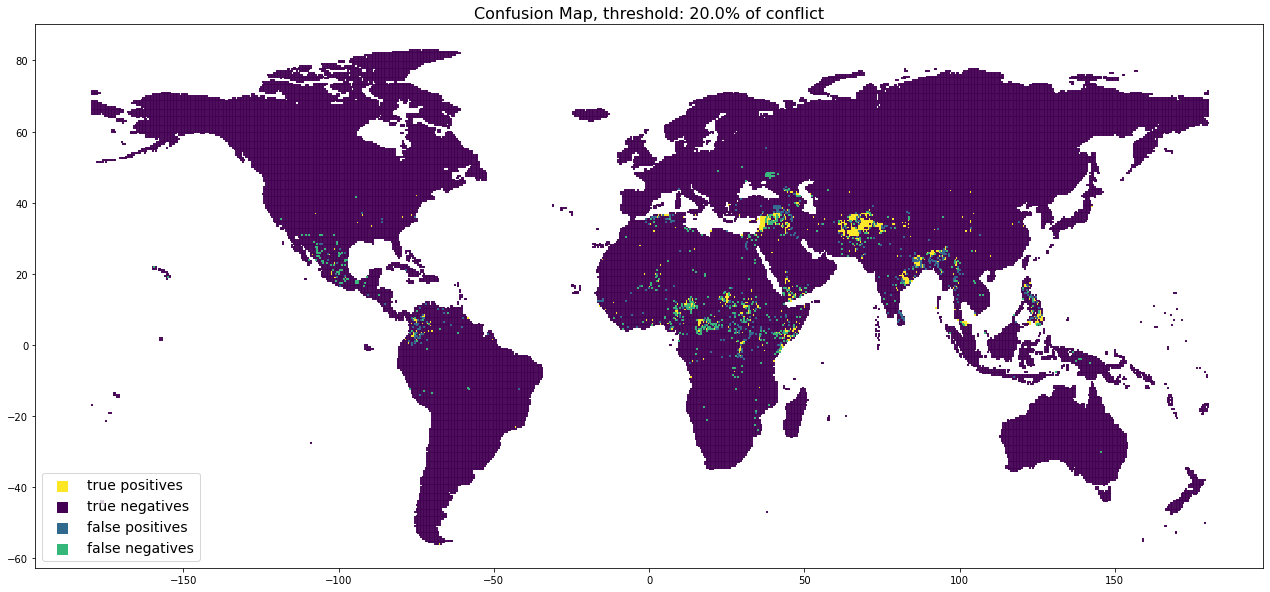

In [20]:
envents_true = y_val['binary_best_t1']

grid['TP_t1'] = ((envents_true.values == 1) & (events_predicted.values == 1))*1
grid['TN_t1'] = (envents_true.values == 0) & (events_predicted.values == 0)*1
grid['FP_t1'] = (envents_true.values == 0) & (events_predicted.values == 1)*1
grid['FN_t1'] = (envents_true.values == 1) & (events_predicted.values == 0)*1


cats_list = ['TP_t1','TN_t1','FP_t1','FN_t1']
labels = ['true positives', 'true negatives', 'false positives', 'false negatives']

viridis = cm.get_cmap('viridis', 4)
colors = [viridis.colors[3],viridis.colors[0],viridis.colors[1],viridis.colors[2]]
# colors = ['steelblue','maroon','lightsteelblue','indianred']


plt.figure(figsize = [22,10])

for i, j in enumerate(cats_list):
    
    sub_set = grid[grid[j] == 1]
    plt.scatter(sub_set['xcoord'], sub_set['ycoord'], color =colors[i], s=1, marker='s',  label = labels[i])
    
plt.title(f'Confusion Map, threshold: {threshold*100}% of conflict', fontsize = 16)
plt.legend(fontsize = 14, markerscale = 10, loc = 3)
plt.show()